# BIG CAT CLASSIFICATION

## Importing Necessary Packages 

In [1]:
import torch
import numpy as np
from tqdm.auto import tqdm
import os

from torch import nn

from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0,EfficientNet_B0_Weights
from torchinfo import summary

from PIL import Image

from matplotlib import pyplot as plt

D:\Python Projects For Github\Tiger Classifier\tiger\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
print(torch.__version__)
device

2.0.0+cu117


'cuda'

## PreProcessing Data

In [4]:
ROOT_DIR = 'tiger_dataset'

TEST_DIR = os.path.join(ROOT_DIR,'test')

TRAIN_DIR = os.path.join(ROOT_DIR,'train')

VAL_DIR = os.path.join(ROOT_DIR,'valid')

TEST_DIR,TRAIN_DIR,VAL_DIR

('tiger_dataset\\test', 'tiger_dataset\\train', 'tiger_dataset\\valid')

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

In [6]:
train_data = ImageFolder(TRAIN_DIR,transform=train_transform)
test_data = ImageFolder(TEST_DIR,transform=train_transform)
valid_data = ImageFolder(VAL_DIR,transform=valid_transform)


train_loader = DataLoader(train_data,shuffle=True,batch_size=32)
test_loader = DataLoader(test_data,shuffle=False,batch_size=32)
valid_loader = DataLoader(valid_data,shuffle=False,batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Before and after transform')

<Figure size 2400x800 with 0 Axes>

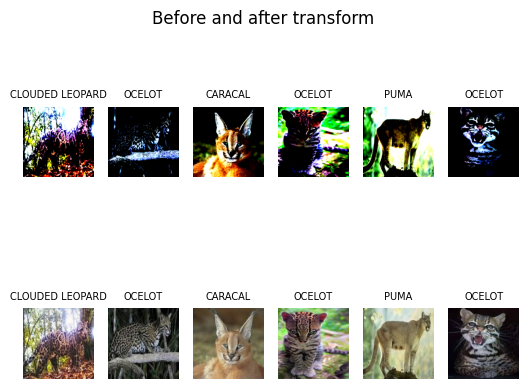

In [7]:
import random
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]



random_samples_idx = random.sample(range(len(train_data)), k=6)


plt.figure(figsize=(24, 8))
fig,ax = plt.subplots(2,6)


for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = train_data[targ_sample][0], train_data[targ_sample][1]

    targ_image_adjust = targ_image.permute(1, 2, 0)

        
    ax[0,i].imshow(targ_image_adjust)
    ax[0,i].axis("off")
    title = f"{train_data.classes[targ_label]}"
    ax[0,i].set_title(title, fontsize = 7)
    
    trans_img = (targ_image_adjust.numpy() * std + mean).clip(0,1)
    ax[1,i].imshow(trans_img)
    ax[1,i].axis("off")
    ax[1,i].set_title(f"{title}",fontsize = 7)
    
fig.suptitle("Before and after transform")

## Model setup and tuning

In [8]:
weights = EfficientNet_B0_Weights.DEFAULT

In [9]:
effnet = efficientnet_b0(weights=weights)

In [10]:
for param in effnet.parameters():
    param.requires_grad = False

In [11]:
effnet.classifier[1] = nn.Sequential(
    nn.BatchNorm1d(num_features=1280),    
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.BatchNorm1d(num_features=512),
    nn.Dropout(0.4),
    nn.Linear(512, 10),
    )

In [12]:
summary(effnet,input_size = [32, 3, 224, 224])

D:\Python Projects For Github\Tiger Classifier\tiger\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
D:\Python Projects For Github\Tiger Classifier\tiger\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 10]                  --
├─Sequential: 1-1                                       [32, 1280, 7, 7]          --
│    └─Conv2dNormActivation: 2-1                        [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        (864)
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        (64)
│    │    └─SiLU: 3-3                                   [32, 32, 112, 112]        --
│    └─Sequential: 2-2                                  [32, 16, 112, 112]        --
│    │    └─MBConv: 3-4                                 [32, 16, 112, 112]        (1,448)
│    └─Sequential: 2-3                                  [32, 24, 56, 56]          --
│    │    └─MBConv: 3-5                                 [32, 24, 56, 56]          (6,004)
│    │    └─MBConv: 3-6                      

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnet.parameters(), lr = 0.001)
effnet.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Training and Test Loop

In [14]:
ImageFolder.LOAD_TRUNCATED_IMAGES = True

def train_step(loader, model, optimizer, loss_fn):

    train_loss = 0.0
    train_acc = 0.0

    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        # move to GPU
        data, target = data.to(device), target.to(device)
          
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
           
        output_class = torch.argmax(torch.softmax(output, dim=1), dim=1)
        train_acc += (output_class == target).sum().item()/len(output) 
            
    train_loss /= len(loader)
    train_acc /= len(loader)
    
    return train_loss, train_acc

In [15]:
def test_step(model: torch.nn.Module, 
              loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (data, targets) in enumerate(loader):
            # Send data to target device
            data, targets = data.to(device), targets.to(device)
    
            # 1. Forward pass
            output_logits = model(data)

            # 2. Calculate and accumulate loss
            loss = loss_fn(output_logits, targets)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            output_labels = output_logits.argmax(dim=1)
            test_acc += ((output_labels == targets).sum().item()/len(output_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(loader)
    test_acc = test_acc / len(loader)
    return test_loss, test_acc

In [16]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=effnet,
                                           loader=train_loader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=effnet,
            loader=test_loader,
            loss_fn=loss_fn)
        
        # 4. Print
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## Training the model

In [48]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 100

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=effnet, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  2%|█▋                                                                                 | 1/50 [00:08<06:46,  8.30s/it]

Epoch: 1 | train_loss: 0.0356 | train_acc: 0.9872 | test_loss: 0.0544 | test_acc: 0.9844


  4%|███▎                                                                               | 2/50 [00:15<06:00,  7.52s/it]

Epoch: 2 | train_loss: 0.0214 | train_acc: 0.9944 | test_loss: 0.0666 | test_acc: 0.9688


  6%|████▉                                                                              | 3/50 [00:22<05:40,  7.23s/it]

Epoch: 3 | train_loss: 0.0269 | train_acc: 0.9914 | test_loss: 0.0514 | test_acc: 0.9688


  8%|██████▋                                                                            | 4/50 [00:29<05:27,  7.11s/it]

Epoch: 4 | train_loss: 0.0200 | train_acc: 0.9944 | test_loss: 0.1611 | test_acc: 0.9531


 10%|████████▎                                                                          | 5/50 [00:36<05:17,  7.06s/it]

Epoch: 5 | train_loss: 0.0253 | train_acc: 0.9932 | test_loss: 0.0652 | test_acc: 0.9844


 12%|█████████▉                                                                         | 6/50 [00:42<05:08,  7.00s/it]

Epoch: 6 | train_loss: 0.0208 | train_acc: 0.9932 | test_loss: 0.1363 | test_acc: 0.9688


 14%|███████████▌                                                                       | 7/50 [00:49<04:59,  6.97s/it]

Epoch: 7 | train_loss: 0.0210 | train_acc: 0.9936 | test_loss: 0.1258 | test_acc: 0.9688


 16%|█████████████▎                                                                     | 8/50 [00:56<04:52,  6.96s/it]

Epoch: 8 | train_loss: 0.0165 | train_acc: 0.9936 | test_loss: 0.1311 | test_acc: 0.9688


 18%|██████████████▉                                                                    | 9/50 [01:03<04:44,  6.94s/it]

Epoch: 9 | train_loss: 0.0169 | train_acc: 0.9944 | test_loss: 0.1284 | test_acc: 0.9844


 20%|████████████████▍                                                                 | 10/50 [01:21<06:52, 10.30s/it]

Epoch: 10 | train_loss: 0.0184 | train_acc: 0.9953 | test_loss: 0.1379 | test_acc: 0.9688


 22%|██████████████████                                                                | 11/50 [01:30<06:21,  9.77s/it]

Epoch: 11 | train_loss: 0.0131 | train_acc: 0.9953 | test_loss: 0.0473 | test_acc: 0.9844


 24%|███████████████████▋                                                              | 12/50 [01:37<05:38,  8.90s/it]

Epoch: 12 | train_loss: 0.0229 | train_acc: 0.9914 | test_loss: 0.0626 | test_acc: 0.9844


 26%|█████████████████████▎                                                            | 13/50 [01:43<05:07,  8.32s/it]

Epoch: 13 | train_loss: 0.0187 | train_acc: 0.9940 | test_loss: 0.0830 | test_acc: 0.9844


 28%|██████████████████████▉                                                           | 14/50 [01:50<04:44,  7.90s/it]

Epoch: 14 | train_loss: 0.0137 | train_acc: 0.9961 | test_loss: 0.0223 | test_acc: 1.0000


 30%|████████████████████████▌                                                         | 15/50 [01:57<04:27,  7.63s/it]

Epoch: 15 | train_loss: 0.0148 | train_acc: 0.9966 | test_loss: 0.0560 | test_acc: 0.9688


 32%|██████████████████████████▏                                                       | 16/50 [02:04<04:12,  7.42s/it]

Epoch: 16 | train_loss: 0.0109 | train_acc: 0.9979 | test_loss: 0.0855 | test_acc: 0.9566


 34%|███████████████████████████▉                                                      | 17/50 [02:11<03:59,  7.26s/it]

Epoch: 17 | train_loss: 0.0144 | train_acc: 0.9953 | test_loss: 0.0348 | test_acc: 0.9844


 36%|█████████████████████████████▌                                                    | 18/50 [02:18<03:49,  7.16s/it]

Epoch: 18 | train_loss: 0.0161 | train_acc: 0.9957 | test_loss: 0.1061 | test_acc: 0.9844


 38%|███████████████████████████████▏                                                  | 19/50 [02:25<03:39,  7.09s/it]

Epoch: 19 | train_loss: 0.0096 | train_acc: 0.9974 | test_loss: 0.0748 | test_acc: 0.9844


 40%|████████████████████████████████▊                                                 | 20/50 [02:32<03:31,  7.05s/it]

Epoch: 20 | train_loss: 0.0124 | train_acc: 0.9957 | test_loss: 0.1621 | test_acc: 0.9844


 42%|██████████████████████████████████▍                                               | 21/50 [02:39<03:23,  7.01s/it]

Epoch: 21 | train_loss: 0.0138 | train_acc: 0.9953 | test_loss: 0.1067 | test_acc: 0.9688


 44%|████████████████████████████████████                                              | 22/50 [02:46<03:15,  6.98s/it]

Epoch: 22 | train_loss: 0.0137 | train_acc: 0.9953 | test_loss: 0.0840 | test_acc: 0.9844


 46%|█████████████████████████████████████▋                                            | 23/50 [02:53<03:07,  6.96s/it]

Epoch: 23 | train_loss: 0.0285 | train_acc: 0.9902 | test_loss: 0.0322 | test_acc: 0.9844


 48%|███████████████████████████████████████▎                                          | 24/50 [03:00<03:00,  6.95s/it]

Epoch: 24 | train_loss: 0.0158 | train_acc: 0.9957 | test_loss: 0.0744 | test_acc: 0.9844


 50%|█████████████████████████████████████████                                         | 25/50 [03:07<02:53,  6.94s/it]

Epoch: 25 | train_loss: 0.0162 | train_acc: 0.9923 | test_loss: 0.0278 | test_acc: 0.9844


 52%|██████████████████████████████████████████▋                                       | 26/50 [03:14<02:46,  6.94s/it]

Epoch: 26 | train_loss: 0.0186 | train_acc: 0.9940 | test_loss: 0.0863 | test_acc: 0.9844


 54%|████████████████████████████████████████████▎                                     | 27/50 [03:21<02:39,  6.94s/it]

Epoch: 27 | train_loss: 0.0126 | train_acc: 0.9970 | test_loss: 0.1134 | test_acc: 0.9688


 56%|█████████████████████████████████████████████▉                                    | 28/50 [03:27<02:32,  6.94s/it]

Epoch: 28 | train_loss: 0.0125 | train_acc: 0.9974 | test_loss: 0.0267 | test_acc: 0.9844


 58%|███████████████████████████████████████████████▌                                  | 29/50 [03:34<02:25,  6.93s/it]

Epoch: 29 | train_loss: 0.0111 | train_acc: 0.9974 | test_loss: 0.1329 | test_acc: 0.9531


 60%|█████████████████████████████████████████████████▏                                | 30/50 [03:41<02:18,  6.93s/it]

Epoch: 30 | train_loss: 0.0130 | train_acc: 0.9953 | test_loss: 0.1280 | test_acc: 0.9688


 62%|██████████████████████████████████████████████████▊                               | 31/50 [03:48<02:11,  6.93s/it]

Epoch: 31 | train_loss: 0.0136 | train_acc: 0.9957 | test_loss: 0.0447 | test_acc: 0.9688


 64%|████████████████████████████████████████████████████▍                             | 32/50 [03:55<02:04,  6.93s/it]

Epoch: 32 | train_loss: 0.0129 | train_acc: 0.9957 | test_loss: 0.1530 | test_acc: 0.9688


 66%|██████████████████████████████████████████████████████                            | 33/50 [04:02<01:58,  6.97s/it]

Epoch: 33 | train_loss: 0.0148 | train_acc: 0.9953 | test_loss: 0.1570 | test_acc: 0.9688


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [04:10<01:55,  7.24s/it]

Epoch: 34 | train_loss: 0.0190 | train_acc: 0.9936 | test_loss: 0.1163 | test_acc: 0.9531


 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [04:18<01:50,  7.37s/it]

Epoch: 35 | train_loss: 0.0149 | train_acc: 0.9953 | test_loss: 0.0672 | test_acc: 0.9688


 72%|███████████████████████████████████████████████████████████                       | 36/50 [04:25<01:43,  7.39s/it]

Epoch: 36 | train_loss: 0.0159 | train_acc: 0.9944 | test_loss: 0.0078 | test_acc: 1.0000


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [04:32<01:35,  7.33s/it]

Epoch: 37 | train_loss: 0.0215 | train_acc: 0.9923 | test_loss: 0.1488 | test_acc: 0.9688


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [04:39<01:26,  7.21s/it]

Epoch: 38 | train_loss: 0.0226 | train_acc: 0.9919 | test_loss: 0.0203 | test_acc: 1.0000


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [04:46<01:18,  7.12s/it]

Epoch: 39 | train_loss: 0.0303 | train_acc: 0.9892 | test_loss: 0.1843 | test_acc: 0.9531


 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [04:53<01:10,  7.06s/it]

Epoch: 40 | train_loss: 0.0307 | train_acc: 0.9889 | test_loss: 0.0562 | test_acc: 0.9844


 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [05:00<01:03,  7.03s/it]

Epoch: 41 | train_loss: 0.0211 | train_acc: 0.9919 | test_loss: 0.1899 | test_acc: 0.9688


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [05:07<00:56,  7.04s/it]

Epoch: 42 | train_loss: 0.0287 | train_acc: 0.9914 | test_loss: 0.0859 | test_acc: 0.9688


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [05:14<00:49,  7.02s/it]

Epoch: 43 | train_loss: 0.0366 | train_acc: 0.9893 | test_loss: 0.0564 | test_acc: 0.9688


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [05:21<00:42,  7.02s/it]

Epoch: 44 | train_loss: 0.0191 | train_acc: 0.9936 | test_loss: 0.0575 | test_acc: 0.9688


 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [05:28<00:35,  7.00s/it]

Epoch: 45 | train_loss: 0.0288 | train_acc: 0.9901 | test_loss: 0.0872 | test_acc: 0.9688


 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [05:35<00:28,  7.01s/it]

Epoch: 46 | train_loss: 0.0273 | train_acc: 0.9902 | test_loss: 0.2176 | test_acc: 0.9531


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [05:42<00:21,  7.01s/it]

Epoch: 47 | train_loss: 0.0280 | train_acc: 0.9906 | test_loss: 0.1151 | test_acc: 0.9688


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [05:50<00:14,  7.16s/it]

Epoch: 48 | train_loss: 0.0190 | train_acc: 0.9936 | test_loss: 0.1958 | test_acc: 0.9375


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [05:57<00:07,  7.19s/it]

Epoch: 49 | train_loss: 0.0208 | train_acc: 0.9927 | test_loss: 0.0875 | test_acc: 0.9688


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [06:04<00:00,  7.29s/it]

Epoch: 50 | train_loss: 0.0268 | train_acc: 0.9902 | test_loss: 0.0986 | test_acc: 0.9531
Total training time: 364.373 seconds


## Plotting Accuracy & Loss

In [49]:
model_results

{'train_loss': [0.03563150029776184,
  0.021421093571044453,
  0.026923453700027033,
  0.020033150615508682,
  0.025316077967856895,
  0.020779913342765164,
  0.02102848536682583,
  0.016452525948072234,
  0.016859353064281917,
  0.018379065145145184,
  0.013097018637767776,
  0.022852760443802005,
  0.01872719263606896,
  0.013745217741951856,
  0.014760308500502119,
  0.01093069121380311,
  0.014363962882644918,
  0.016069256482097283,
  0.009644667031514547,
  0.012384162878470929,
  0.013827676398437214,
  0.013721598765560847,
  0.028509644713342087,
  0.015828135582835298,
  0.016218493767529214,
  0.018554152565217284,
  0.012643197926928685,
  0.012500001781792317,
  0.011139510989217854,
  0.012956663132134876,
  0.013605249852894116,
  0.012932141160664996,
  0.014791294986586252,
  0.01904058386212891,
  0.014863794125705855,
  0.01593776458610417,
  0.021493800613576267,
  0.022552125812556008,
  0.030327043820599937,
  0.030706293125834623,
  0.021056136703844285,
  0.0286

In [50]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

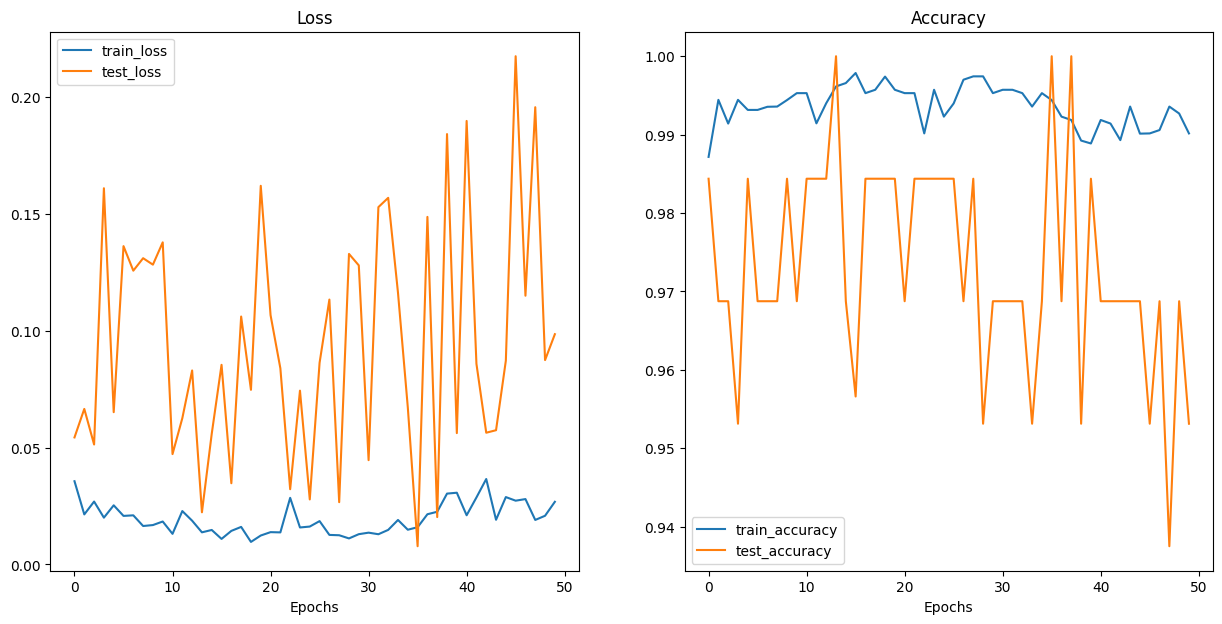

In [51]:
plot_loss_curves(model_results)

## Making Prediction on an Image

In [52]:
class_names = train_data.classes
class_names

['AFRICAN LEOPARD',
 'CARACAL',
 'CHEETAH',
 'CLOUDED LEOPARD',
 'JAGUAR',
 'LIONS',
 'OCELOT',
 'PUMA',
 'SNOW LEOPARD',
 'TIGER']

In [53]:
import torchvision

custom_image_path = "tiger_dataset/valid/TIGER/5.jpg"

# Read in custom image
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255

In [54]:
effnet.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_with_batch_size = custom_image.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = effnet(custom_image.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 224, 224])
Unsqueezed custom image shape: torch.Size([1, 3, 224, 224])


In [55]:
custom_image_pred

tensor([[ 0.4899, -5.9064, -6.2481,  7.0494,  2.2026,  1.8530, -0.4964, -6.2911,
          3.0910,  8.8653]], device='cuda:0')

In [56]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.4899, -5.9064, -6.2481,  7.0494,  2.2026,  1.8530, -0.4964, -6.2911,
          3.0910,  8.8653]], device='cuda:0')
Prediction probabilities: tensor([[1.9726e-04, 3.2899e-07, 2.3376e-07, 1.3926e-01, 1.0936e-03, 7.7096e-04,
         7.3569e-05, 2.2392e-07, 2.6589e-03, 8.5595e-01]], device='cuda:0')
Prediction label: tensor([9], device='cuda:0')


In [57]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'TIGER'

In [58]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[1.9726e-04, 3.2899e-07, 2.3376e-07, 1.3926e-01, 1.0936e-03, 7.7096e-04,
         7.3569e-05, 2.2392e-07, 2.6589e-03, 8.5595e-01]], device='cuda:0')

In [59]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path, 
                        class_names, 
                        transform,
                        device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

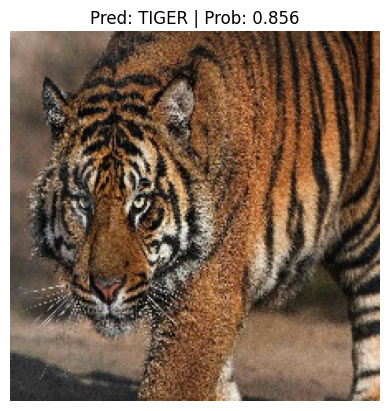

In [60]:
# Pred on our custom image
pred_and_plot_image(model=effnet,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=None,
                    device=device)

In [72]:
def predict_image(data_path, class_names):
    image = Image.open(data_path)
    image_trans = torchvision.io.read_image(str(data_path)).type(torch.float32).to(device)
    image_trans = image_trans / 255.
    
    image_trans = image_trans.unsqueeze(dim=0)
    y_logits = effnet(image_trans)
    y_preds = torch.softmax(y_logits, dim = 1)
    y_preb_probs = torch.argmax(y_preds, dim = 1)  # not used anyway
    
    
    fig,ax = plt.subplots(1,2)
    fig.tight_layout(pad=6)
    ax[0].imshow(image)
    ax[0].set_title('Image')
    x=y_preds.cpu().detach().numpy()[0] * 100
    y=class_names
    ax[1].barh(y,x)

    fig.suptitle("Predict function for EfficientNet B0")
    plt.xlabel("Confidence")
    plt.ylabel("Classes")

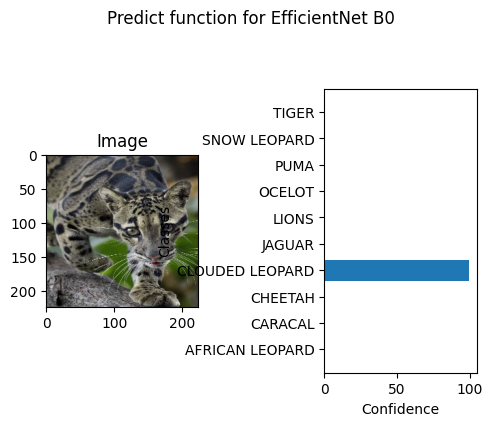

In [73]:
predict_image("tiger_dataset/valid/CLOUDED LEOPARD/5.jpg", train_data.classes)

## Accuracy on Validation Dataset

In [74]:
valid_loader

In [77]:
def val_model(model: torch.nn.Module, 
              loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    val_loss, val_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (data, targets) in enumerate(loader):
            # Send data to target device
            data, targets = data.to(device), targets.to(device)
    
            # 1. Forward pass
            output_logits = model(data)

            # 2. Calculate and accumulate loss
            loss = loss_fn(output_logits, targets)
            val_loss += loss.item()
            
            # Calculate and accumulate accuracy
            output_labels = output_logits.argmax(dim=1)
            val_acc += ((output_labels == targets).sum().item()/len(output_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    val_loss = val_loss / len(loader)
    val_acc = val_acc / len(loader)
    return val_loss, val_acc

In [79]:
lossvalidation,accvalidation = val_model(effnet,valid_loader,loss_fn)

In [80]:
print(f"Accuarcy of EfficientNet custom Model on validation dataset: {accvalidation}")
print(f"Loss of EfficientNet Custom model on validation dataset: {lossvalidation}")

Accuarcy of EfficienNet custom Model on validation dataset: 0.8
Loss of EfficientNet Custom model on validation dataset: 0.751541162906324


**This accuracy is based on just 5 pictures in validation datset if there were more the accuracy would almost reach 90%** 

## Confusion Metrics and other Metrics

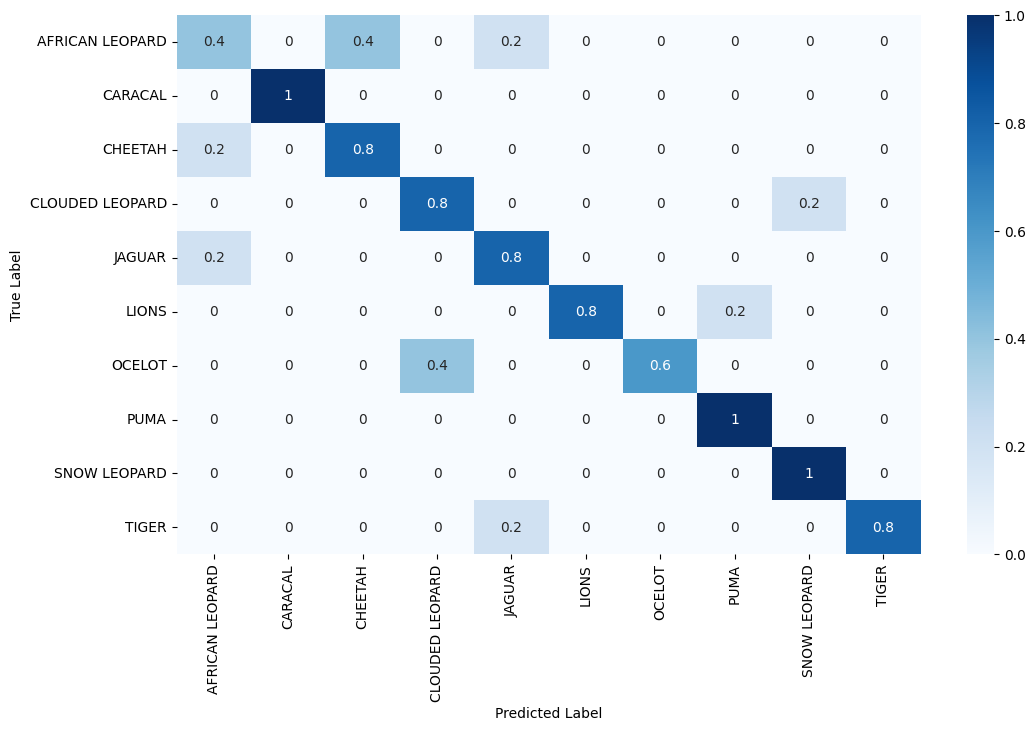

In [102]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

effnet.eval()
# iterate over test data
with torch.inference_mode():
    for batch,(inputs, labels) in enumerate(valid_loader):
        
        inputs, labels = inputs.to(device),labels.to(device)
        output = effnet(inputs) # Feed Network

        output = torch.argmax(output, dim=1).cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in class_names],
                     columns = [i for i in class_names])
plt.figure(figsize = (12,7))
s = sn.heatmap(df_cm, annot=True,cmap="Blues")
s.set(xlabel='Predicted Label', ylabel='True Label')
plt.savefig('cmatrixEffnet.png')

## Saving Model

In [81]:
SAVE_DIR = 'Best_model/EfficienNet B0'

In [82]:
import os

if os.path.exists(SAVE_DIR):
    print('path Found')
else:
    os.mkdir(SAVE_DIR)

In [84]:
model_path = os.path.join(SAVE_DIR, "EfficientNet_B0_catClassifier"+".pth")
torch.save(effnet.state_dict(), model_path)